In [1]:
import pyupbit

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

from tensorflow.keras.regularizers import l2


In [51]:
df_bit = pyupbit.get_ohlcv("KRW-BTC",count = 2200, period=1,interval= "minute240", to="20241204")

In [5]:
df_doge= pyupbit.get_ohlcv("KRW-DOGE",count = 2200, period=1,interval= "minute240", to="20241204")

In [12]:
del df_bit['value']

In [54]:
df_bit.head()

,open,high,low,close,volume,value
2023-12-03 13:00:00,52636000.0,52762000.0,52591000.0,52709000.0,296.344152,1.561229e+10
2023-12-03 17:00:00,52718000.0,52876000.0,52701000.0,52762000.0,444.267681,2.344845e+10
2023-12-03 21:00:00,52770000.0,53362000.0,52717000.0,53130000.0,1173.940326,6.230149e+10
2023-12-04 05:00:00,53130000.0,53864000.0,53015000.0,53700000.0,881.992359,4.726996e+10
2023-12-04 09:00:00,53761000.0,55106000.0,53690000.0,54597000.0,2733.614399,1.490599e+11


In [13]:
del df_doge['value']

In [25]:
df_bit_reset = df_bit.reset_index(drop=True)

In [26]:
df_doge_reset = df_doge.reset_index(drop=True)

In [11]:
# 정규화 함수
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)     

In [30]:
bit_data_x = MinMaxScaler(df_bit_reset)


In [34]:
bit_data_last = bit_data_x['close']

In [35]:
x = bit_data_x.values.tolist()
y = bit_data_last.values.tolist()

In [37]:
data_x = []
data_y = []
window_size = 10     # 이전 10일 Open, High, Low, Volume, Close 데이터로 다음 날 종가 예측

for i in range(len(y) - window_size):
    x2 = x[i : i + window_size] # 10일치 데이터
    y2 = y[i + window_size] # 11일째 날 데이터
    data_x.append(x2)
    data_y.append(y2)

In [ ]:
# 훈련용 데이터셋 80%
train_size = int(len(data_y) * 0.8)
train_x = np.array(data_x[0:train_size])
train_y = np.array(data_y[0:train_size])

# 테스트용 데이터셋 20%
test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size:len(data_x)])
test_y = np.array(data_y[train_size:len(data_y)])

In [39]:
print(train_size)
print(test_size)

1752
438


In [48]:
model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(64, return_sequences=True, input_shape=(window_size, 5), activation='relu'))
# 출력노드 20% 비활성화
model.add(Dropout(0.2))

# 두 번째 LSTM 층
model.add(LSTM(32, activation='relu'))
# 출력노드 20% 비활성화
model.add(Dropout(0.2))

# 출력층(완전 연결 구조)
model.add(Dense(1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error') # Optimizer : adam, 손실 함수:MSE
model.fit(train_x, train_y, epochs=50, batch_size=30, validation_split=0.2) # epochs: 전체 데이터 학습 횟수, batch_size: 한 번에 제공되는 훈련 데이터 수
pred_y = model.predict(test_x)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0689 - val_loss: 5.3466e-04
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 5.0011e-04
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 4.6431e-04
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 5.0621e-04
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 5.1691e-04
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 8.8266e-04
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - val_loss: 5.6981e-04
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 5.8405e-04
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 4.2511e-04
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 4.1645e-04
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 4.1856e-04
Epoch 12/50
47/47 ━━━━━━━━━━━

In [49]:
# 역정규화 함수
def inverse_MinMaxScaler(normalized_data, original_data):
    original_min = np.min(original_data, 0)
    original_max = np.max(original_data, 0)
    return normalized_data * (original_max - original_min) + original_min

# 예측값과 실제값을 원래 스케일로 역변환
test_y_original = inverse_MinMaxScaler(test_y, bit_data_x['close'])
pred_y_original = inverse_MinMaxScaler(pred_y, bit_data_x['close'])

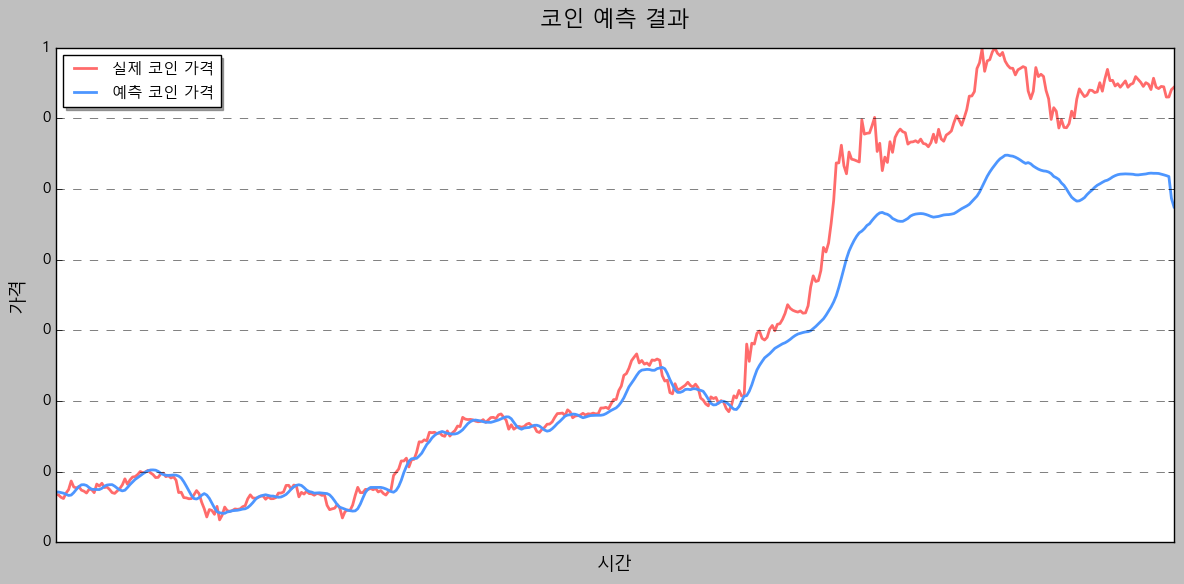

In [50]:
# 그래프 그리기
plt.style.use('classic')
plt.figure(figsize=(12, 6), dpi=100)

# 폰트 설정
plt.rc('font', family='Malgun Gothic', size=12)
plt.rc('axes', titlesize=16, labelsize=13)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)

# 데이터 플로팅
plt.plot(test_y_original, color='#FF6B6B', linewidth=2, label='실제 코인 가격')
plt.plot(pred_y_original, color='#4D96FF', linewidth=2, label='예측 코인 가격')

# 제목 및 레이블 설정
plt.title('코인 예측 결과', pad=15)
plt.xlabel('시간', labelpad=10)
plt.ylabel('가격', labelpad=10)

# x축의 숫자 레이블 제거
plt.xticks([])

# 범례 설정
plt.legend(loc='best', frameon=True, shadow=True, fontsize=11)

# 그리드 설정
plt.grid(True, linestyle='--', alpha=0.7)

# y축 포맷 설정 (천 단위 콤마)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 여백 자동 조정
plt.tight_layout()

# 그래프 표시
plt.show()